<a href="https://colab.research.google.com/github/urmzd/md-nlp/blob/main/src/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install pyppeteer
!pip install ipython ipykernel --upgrade

In [47]:
!apt-get update 
!apt-get install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!dpkg -L chromium-chromedriver

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 https://dl.google.com/linux/chrome/deb stable InRelease
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/pp

In [48]:
import random
from numpy import random as nprd
import tensorflow as tf
tf.random.set_seed(42)
random.seed(42)
nprd.seed(42)

In [49]:
import asyncio
import re
import csv
import pyppeteer as ptr
import pandas as pd
import nltk
from typing import Optional, TypeVar
from typing import Callable
from glob import glob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [52]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
resource_path = "/content/drive/MyDrive/resources/"

data_path = resource_path + "data/"
data_source_path = data_path + "sources"
data_target_path = data_path + "targets"

In [55]:
from typing import List, Tuple
PosTag = Tuple[str, str]
PosTagList = List[PosTag]
StemWord = str
StemWordList = List[StemWord]

In [56]:
global_config = {
    "word_limit": 56,
    "n_samples": 1000,
    "test_size": 0.2
}

In [57]:
def get_name_and_extension(file_path: str) -> Tuple[str, str]:
    regex = re.compile(r"(.*)/(.*)\.(.*)")
    return regex.match(file_path).group(2,3)

In [58]:
async def download_html(browser: ptr.browser.Browser, page: ptr.page.Page, url: str, selector: str) -> Optional[str]:
    await page.goto(url, waitUntil="load", timeout=0)
    print(f"Going to collect from {url} using selector {selector}")
    content = await page.querySelector(selector)

    html = ''
    if content:
        html = await page.evaluate('(element) => element.textContent', content)
        
    return html

def write_to_resource_target(target_path: str, file_name: str, content: StemWordList, extension="txt") -> None:
    with open(f"{target_path}/{file_name}.{extension}", "w") as file:
        file.write("\n".join(content))


async def get_training_data_from_folder(source_path: str, target_path: str, force=False) -> None:
    browser = await ptr.launch(
        executablePath="/usr/bin/chromium-browser", 
        args= ['--no-sandbox']
    )
    page = await browser.newPage()
    
    glob_pattern = "/**/*"
    source_files = glob(source_path + glob_pattern, recursive=True)
    target_files = glob(target_path + glob_pattern, recursive=True)
    target_file_names = [get_name_and_extension(file_path)[0] for file_path in target_files]
    
    for file_path in source_files:
        [file_name, file_extension] = get_name_and_extension(file_path)
        
        if not file_name in target_file_names or force:
            result = await get_training_data(browser, page, file_path)
            write_to_resource_target(target_path, file_name, result)        
                
    await browser.close()

async def get_training_data(browser: ptr.browser.Browser, page: ptr.page.Page, file_path: str) -> StemWordList:
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)

    words = []
    if isinstance(df, pd.DataFrame):
        for _, row in df.iterrows():
            result = await download_html(browser, page, row["link"], row["selector"])
            words.extend(clean_up_words(tokenize(result)))
    
    return words

In [59]:
T = TypeVar("T")
R = TypeVar("R")

TestValueStrCallable = Callable[[T], str]
TestValueBoolCallable = Callable[[T], bool]
ValueTestFnCallable = Callable[[T], TestValueStrCallable]
FilterCallable = Callable[[ValueTestFnCallable], bool]
MapCallable = Callable[[ValueTestFnCallable], str]

def tokenize(data: str) -> PosTagList:
    tokenized_words = nltk.word_tokenize(data)
    mutated_words = nltk.pos_tag(tokenized_words)
    return mutated_words

def filter_words(x: T, test_value: TestValueStrCallable, *fns: FilterCallable) -> bool:
    if fns:
        if fns[0](x, test_value):
            return filter_words(x, test_value, *fns[1:])
        else:
            return False
    
    return True
    
def filter_by_punctuation(x: T, test_value: TestValueStrCallable = lambda t: t[0]) -> bool:
    return x[0] != x[1]

def filter_by_stop_word(x: T, test_value: TestValueStrCallable = lambda t: t[0]) -> bool:
    return test_value(x) not in stopwords.words("english")

def regex_filter(regex: str):
    def filter_by_regex(x: T, test_value: TestValueStrCallable = lambda t: t[0]):
        rgx = re.compile(regex)
        return rgx.match(test_value(x))
    return filter_by_regex

filter_by_alphabet = regex_filter(r"^([a-zA-Z]|')+$")
filter_by_apostrophe = regex_filter(r"^[^']*$")

def map_by_stem_words(x: PosTag, test_value: TestValueStrCallable = lambda t: t[0], ps=PorterStemmer()) -> StemWord:
    return ps.stem(test_value(x)).lower()

def map_words(x: T, test_value: TestValueStrCallable, *fns: MapCallable) -> StemWord:
    if fns:
        return map_words(fns[0](test_value(x)), test_value, *fns[1:])

    return x
            
def clean_up_words(words: PosTagList) -> StemWordList:
    filtered_words = list(set(
        filter(
        lambda x: filter_words(x, lambda x: x[0], filter_by_punctuation, filter_by_stop_word, filter_by_alphabet),
        words
        )
    ))

    stem_words = list(set(map(lambda x: map_words(x, lambda x: x, map_by_stem_words), filtered_words)))
    
    return list(set(
        filter(
            lambda x: filter_words(x, lambda x: x, filter_by_apostrophe), 
            stem_words)
    ))

In [60]:
!curl -sSL https://dl.google.com/linux/linux_signing_key.pub | apt-key add -
!echo "deb [arch=amd64] https://dl.google.com/linux/chrome/deb/ stable main" > /etc/apt/sources.list.d/google-chrome.list
!apt update -y && apt install -y google-chrome-stable

OK
Hit:1 https://dl.google.com/linux/chrome/deb stable InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-b

In [61]:
await get_training_data_from_folder(data_source_path, data_target_path, force=True)

URMZD /usr/bin/chromium-browser--disable-background-networking--disable-background-timer-throttling--disable-breakpad--disable-browser-side-navigation--disable-client-side-phishing-detection--disable-default-apps--disable-dev-shm-usage--disable-extensions--disable-features=site-per-process--disable-hang-monitor--disable-popup-blocking--disable-prompt-on-repost--disable-sync--disable-translate--metrics-recording-only--no-first-run--safebrowsing-disable-auto-update--enable-automation--password-store=basic--use-mock-keychain--headless--hide-scrollbars--mute-audioabout:blank--no-sandbox--remote-debugging-port=55215--user-data-dir=/root/.local/share/pyppeteer/.dev_profile/tmp2ay5rqak
Going to collect from https://www.uptodate.com/contents/tetanus-the-basics?search=Patient%20education&source=search_result&selectedTitle=110~150&usage_type=default&display_rank=110 using selector #topicText
Going to collect from  https://www.mayoclinic.org/diseases-conditions/tetanus/symptoms-causes/syc-2035162

In [62]:
from typing import Dict

def get_cleaned_data_from_file(input_file_path: str) -> Optional[List[str]]:
    with open(input_file_path, "r") as file:
        return [word.strip("\n") for word in list(file.readlines())]

def get_cleaned_data_from_folder(input_path: str) -> Dict[str, PosTagList]:
    glob_pattern = "/**/*"
    input_files = glob(input_path + glob_pattern, recursive=True)
    
    data = dict()
    for file_path in input_files:
        [file_name, file_extension] = get_name_and_extension(file_path)
        classification_data = get_cleaned_data_from_file(file_path)
        data[file_name] = classification_data
        
    return data

In [63]:
from nltk.probability import WittenBellProbDist, FreqDist,LaplaceProbDist
import numpy as np

def unpack_dict_list(dict_list: Dict[str, StemWordList]):
    return [v for k in dict_list for v in dict_list[k]]

def generate_sample(population: StemWordList, label: str, n_unique_words: int, word_limit = global_config["word_limit"]):
    freq_dist = FreqDist(population)
    prob_dist = WittenBellProbDist(freq_dist, n_unique_words)
    
    samples = [prob_dist.generate() for _ in range(word_limit)]

    return np.array(list([*samples, label])).reshape(-1, 1)

def generate_samples(data: Dict[str, StemWordList], n_samples = global_config["n_samples"]):
    n_unique_words = len(set(unpack_dict_list(data)))
    
    return np.array([np.array([generate_sample(data[k], k, n_unique_words) for _ in range(n_samples)]) for k in data])

In [64]:
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from typing import Union

def get_one_hot_encoder(population: Dict[str, StemWordList]):
    population_array = np.array(list(set(unpack_dict_list(population)))).reshape(-1, 1)
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(population_array)
    return encoder

def get_label_encoder(labels: np.ndarray):
    encoder = LabelBinarizer()
    encoder.fit(labels)
    return encoder

def transform_data_by_encoder(data: np.ndarray, encoder: Union[OneHotEncoder, LabelBinarizer]):
    encoded_data = encoder.transform(data)
    
    if not isinstance(encoded_data, np.ndarray):
        encoded_data = encoded_data.toarray()
        
    return encoded_data

def split_into_x_y(samples: np.ndarray):
    x = samples[:,:,:-1]
    y = samples[:,:,-1]
    y = y.reshape(y.shape[0]*y.shape[1], 1)
    return (x,y)
    
def transform_x_y(x: np.ndarray, y: np.ndarray, in_coder: OneHotEncoder, out_coder: LabelBinarizer):   
    encoded_x = np.stack([
        transform_data_by_encoder(x[lbl_idx, smpl_idx], in_coder)
        for lbl_idx in range(x.shape[0])
        for smpl_idx in range(x.shape[1])
    ], axis=0)
            
    encoded_y = transform_data_by_encoder(y, out_coder)
    
    return (encoded_x, encoded_y)

In [65]:
import pickle

model_path = resource_path + "models/"
input_encoder_file_name = "input_encoder.pickle"
output_encoder_file_name = "output_encoder.pickle"

def get_x_y(path = data_target_path, n_samples=2000):
    result = get_cleaned_data_from_folder(data_target_path)
    samples = generate_samples(result, n_samples)
    x,y = split_into_x_y(samples)

    encoder_paths = glob(model_path + "*.pickle", recursive=True)
    encoder_file_names = [get_name_and_extension(file_path)[0] for file_path in encoder_paths]

    if input_encoder_file_name in encoder_file_names:
      input_encoder = pickle.load(open(encoder_paths[encoder_file_names.index(input_encoder_file_name)], "rb"))
    else:
      input_encoder = get_one_hot_encoder(result)

    if output_encoder_file_name in encoder_file_names:
      output_encoder = pickle.load(open(encoder_paths[encoder_file_names.index(output_encoder_file_name)], "rb"))
    else:
      output_encoder = get_label_encoder(y)

    pickle.dump(input_encoder, open(model_path + input_encoder_file_name, "wb"))
    pickle.dump(output_encoder, open(model_path + output_encoder_file_name, "wb"))

    return transform_x_y(x, y, input_encoder, output_encoder)

In [66]:
def get_data(n_samples=global_config["n_samples"], test_size=global_config["test_size"], random_state=42):
    x, y = get_x_y(n_samples=n_samples)
    x=x.reshape((*x.shape, 1))
    return train_test_split(x, y, test_size=test_size, random_state=random_state)

x_train, x_test, y_train, y_test = get_data()

tcmalloc: large alloc 5694529536 bytes == 0x55e085e74000 @  0x7ff49762b1e7 0x7ff48de2246e 0x7ff48de72c7b 0x7ff48de72d18 0x7ff48df1a010 0x7ff48df1a73c 0x7ff48df1a85d 0x55dd52c32749 0x7ff48de5fef7 0x55dd52c30437 0x55dd52c30240 0x55dd52ca3973 0x55dd52c9e9ee 0x55dd52c31bda 0x55dd52ca0737 0x55dd52c9eced 0x55dd52b70e2b 0x7ff48de5fef7 0x55dd52c30437 0x55dd52c30240 0x55dd52ca3973 0x55dd52c9e9ee 0x55dd52c31bda 0x55dd52ca0737 0x55dd52c9eced 0x55dd52c31bda 0x55dd52c9f915 0x55dd52c9e9ee 0x55dd52c31bda 0x55dd52ca0737 0x55dd52c31d51
tcmalloc: large alloc 4555628544 bytes == 0x55e1d9ef2000 @  0x7ff49762b1e7 0x7ff48de2246e 0x7ff48de72c7b 0x7ff48de72d18 0x7ff48df053a9 0x7ff48df07ab5 0x55dd52d18409 0x55dd52c9fe7a 0x55dd52c9e9ee 0x55dd52c31bda 0x55dd52ca0737 0x55dd52c9eced 0x55dd52c31bda 0x55dd52c9f915 0x55dd52d22cf8 0x55dd52d18cae 0x55dd52d08ae5 0x55dd52c3f224 0x55dd52c700a4 0x55dd52c30c52 0x55dd52ca3c25 0x55dd52c9eced 0x55dd52c31bda 0x55dd52ca0737 0x55dd52c31d51 0x55dd52c9f915 0x55dd52c9e9ee 0x55dd52c9

In [67]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers, activations

history_path = model_path + "history.npy"
def save_history(history: np.ndarray):
  np.save(history_path, history, allow_pickle=True)

def load_history() -> Dict:
  return np.load(history_path, allow_pickle=True).item()

def run():
    input_shape = x_train.shape[1:]
    vocab_size = input_shape[-2]

    config = {}

    config["conv_layer_0"] = {
        "filters": 5 * vocab_size / 6,
        "kernel_size": (3, vocab_size),
        "strides": (1,1),
        "activation": "relu",
    }

    config["pool_layer_0"] = {
        "pool_size": (3,3),
        "padding": "same"
    }

    config["conv_layer_1"] = {
        "filters": 7 * config["conv_layer_0"]["filters"] / 16,
        "kernel_size": (2, 1),
        "strides": (1,1),
        "activation": "relu"
    }

    config["pool_layer_1"] = {
        "pool_size": (3,3),
        "padding": "same",
    }

    config["dense_layer_5"] = {
        "units": 16,
        "activation": "relu",
        "bias_regularizer": regularizers.l1_l2(3e-1, 17e-1)
    }

    config["dense_layer_6"] = {
        "units": 8,
        "activation": "relu",
        "bias_regularizer": regularizers.l1_l2(1e-1, 18e-1)
    }

    config["dense_layer_7"] = {
        "units": 4,
        "activation": "relu",
        "kernel_regularizer": regularizers.l1_l2(10e-9, 12e-1),
        "bias_regularizer": regularizers.l1_l2(17e-6, 1e-11)
    }

    config["dropout_layer_0"] = {
        "rate": 0.5,
    }

    config["dense_layer_8"]= {
        "units": 8,
        "activation": "relu",
        "kernel_regularizer": regularizers.l1_l2(1e-1, 4e-7),
        "bias_regularizer": regularizers.l1_l2(1e-9, 9e-1)
    }

    config["dropout_layer_1"]= {
        "rate": 0.33
    }

    config["flatten_layer_0"] = {
    }

    config["dense_layer_final"] = {
        "units": (y_train.shape[-1]),
        "activation": "softmax"
    }

    config["model_compile"] = {
        "optimizer": tf.keras.optimizers.Adam(0.001),
        "loss": keras.losses.binary_crossentropy,
        "metrics": ["accuracy", keras.metrics.Recall()]
    }

    config["model_fit"] = {
         "x": x_train,
         "y": y_train,
         "batch_size": 2,
         "epochs": 4,
         "validation_split" : global_config["test_size"]
    }

    encoder_input = keras.Input(shape=input_shape)
    prev_layer = encoder_input
    encoder_output=None

    layer_types = {
        "dense": layers.Dense,
        "flatten": layers.Flatten,
        "dropout": layers.Dropout,
        "conv": layers.Conv2D,
        "pool": layers.MaxPool2D,
        "comp": None,
    }
    
    for k,v in config.items():
      type_of_layer, *_ = k.split("_")
      if type_of_layer != "model":
        encoder_output = layer_types[type_of_layer](**v)(prev_layer)
        prev_layer = encoder_output
    
    config["model"] = {
        "inputs": encoder_input,
        "outputs": encoder_output,
        "name": "encoder"
    }

    model = keras.Model(**config["model"])
    model.compile(**config["model_compile"])

    print(model.summary())
    
    history = model.fit(**config["model_fit"])
    save_history(history.history)

    test_scores = model.evaluate(x_test, y_test, verbose=2)

    return model    

In [68]:
model = run()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 56, 4237, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 54, 1, 3530)       44873360  
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 1, 3530)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 1, 1544)       10902184  
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 1, 1544)       0         
 2D)                                                             
                                                                 
 dense_10 (Dense)            (None, 6, 1, 16)          2472

In [69]:
def clean_up_user_input(sentence: str, word_limit=56):
  tokenized_words = tokenize(sentence)
  
  word = clean_up_words(tokenized_words)
  words_to_test = np.array(word).reshape(-1, 1)

  if not words_to_test.size:
    return np.array([])

  input_encoder = pickle.load(open(model_path + input_encoder_file_name, "rb"))

  encoded_data = transform_data_by_encoder(words_to_test, input_encoder) 
  difference = word_limit - encoded_data.shape[0]
  zero_array = np.zeros(encoded_data.shape[1])

  for _ in range(difference):
    encoded_data = np.append(encoded_data, [zero_array], axis=0)

  return encoded_data

In [70]:
import os

cnn_folder = "cnn"
cnn_path = model_path + cnn_folder

def save_cnn(override:bool=False, model=model):
  if not os.path.exists(cnn_path) or override:
    model.save(cnn_path)

save_cnn(True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/resources/models/cnn/assets


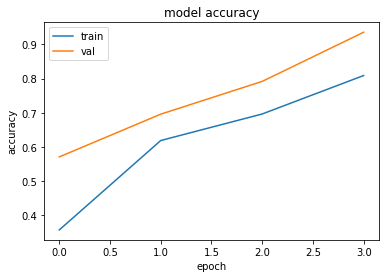

In [71]:
from keras import models
from matplotlib import pyplot as plt

def plot_cnn():
  history = load_history()
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

plot_cnn()

In [73]:
def predict(sentence: str):
  word = clean_up_user_input(sentence)

  if word.size:
    word = word.reshape(*word.shape, 1)
    words = np.array([word])
    output_encoder: LabelBinarizer = pickle.load(open(model_path + output_encoder_file_name, "rb"))
    prediction = model.predict(words)
    prediction_binary = np.zeros_like(prediction)
    prediction_binary[:,prediction.argmax(1)] = 1
    print(prediction)
    ailment:str = output_encoder.inverse_transform(prediction)[0]
    return ailment.upper()

print(predict("I have a headache. I feel senstivity to light. My head is hurting. It's twirling. I feel an aura"))
print(predict("I feel suicidal. Mental health kill hurt someone else medicine need help neuropath"))
print(predict("I have a jaw ache. It's tetanus. My muscles are stiff"))

[[6.9904435e-01 3.0088890e-01 6.6741006e-05]]
DEPRESSION
[[9.7686917e-01 2.3130894e-02 4.3511771e-11]]
DEPRESSION
[[0.02966122 0.40053234 0.56980646]]
TETANUS
